In [ ]:
## Notebook env: mave (mave kernel)
## this notebook allocates randomly selected batches 1,2,3, and 4-6 as four separate datasets to be used for training

In [1]:
import os
os.chdir('/home/ssobti/projects/mir_tud/packages/ciberatac-main/src/mave')
import pandas as pd
import numpy as np
import scanpy as sc
import itertools
import pickle
import shelve
from pathlib import Path

In [2]:
cell_cutoff = 10
weights = [10000.0, 1.0, 1.0, 1.0]
latent_vars = 10
batch = 'all_batches'
max_epoch = 1000
## mini_batch = 128 -- now batch size is total # of cells being trained on
learning_rate = 0.002

In [3]:
weights = list(weights)

In [4]:
## convert float to int if it is an integer
for idx, val in enumerate(weights):
    if isinstance(val, float) and val.is_integer():
        weights[idx] = int(val)

weighting_scheme_folder = f'R{weights[0]}_K{weights[1]}_C{weights[2]}_T{weights[3]}'
weighting_scheme = f'R{weights[0]}_K{weights[1]}_C{weights[2]}_T{weights[3]}_{batch}_ltv{latent_vars}_cellssampled{cell_cutoff}_maxepoch{max_epoch}_learning_rate{learning_rate}_'
Path(f'/home/ssobti/projects/mir_tud/output_data/mave_output/mave_trblsht/tRF/parameter_optimization/{weighting_scheme_folder}/logs').mkdir(parents=True, exist_ok=True)
Path(f'/home/ssobti/projects/mir_tud/output_data/mave_output/mave_trblsht/tRF/parameter_optimization/{weighting_scheme_folder}/models').mkdir(parents=True, exist_ok=True)
Path(f'/home/ssobti/projects/mir_tud/output_data/mave_output/mave_trblsht/tRF/parameter_optimization/{weighting_scheme_folder}/ckpt').mkdir(parents=True, exist_ok=True)

In [5]:
sc.settings.verbosity = 3        # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

2024-04-09 13:27:46.555723: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.0 pandas==1.5.2 scikit-learn==1.2.0 statsmodels==0.13.5 pynndescent==0.5.8


In [6]:
adata = sc.read('/home/ssobti/projects/mir_tud/010523_filtered_data/tRF.concat.raw.adata_gex.guide_assigned.h5ad')

Only considering the two last: ['.guide_assigned', '.h5ad'].
Only considering the two last: ['.guide_assigned', '.h5ad'].


In [7]:
adata.obs

,sample,barcode,guide,lor,pvalue,adj_pvalue,max_umi,n_umi,m_umi,v_umi,log_max_umi,log_n_umi,log_m_umi
tRF_1:AAACCCAAGGCCTTGC-1,tRF_1,AAACCCAAGGCCTTGC,TuD_NC_01,2.144148,1.652448e-15,8.377661e-09,23.0,33.0,0.150685,2.458841,1.361728,1.518514,-0.821930
tRF_1:AAACCCACATATACCG-1,tRF_1,AAACCCACATATACCG,tRF_Arg_ACG_2,7.473168,2.865581e-322,1.452806e-315,182.0,214.0,0.977169,151.260944,2.260071,2.330414,-0.010030
tRF_1:AAACCCACATGACAGG-1,tRF_1,AAACCCACATGACAGG,TuD_NC_01,2.336330,3.615579e-22,1.833044e-15,36.0,53.0,0.242009,5.973273,1.556303,1.724276,-0.616168
tRF_1:AAACCCACATGACGGA-1,tRF_1,AAACCCACATGACGGA,tRF_Arg_ACG_2,1.160519,2.865581e-322,1.452806e-315,214.0,372.0,1.698630,237.780319,2.330414,2.570543,0.230099
tRF_1:AAACCCAGTCAACCAT-1,tRF_1,AAACCCAGTCAACCAT,TuD_NC_01,3.011825,9.624496e-26,4.879475e-19,38.0,51.0,0.232877,6.638180,1.579784,1.707570,-0.632874
...,...,...,...,...,...,...,...,...,...,...,...,...,...
tRF_3:TTTGTTGTCAACCGAT-1,tRF_3,TTTGTTGTCAACCGAT,tRNA-Asn-GTT-8-1.rh,5.613436,2.188911e-183,8.570205e-177,67.0,80.0,0.365297,20.535671,1.826075,1.903090,-0.437354
tRF_3:TTTGTTGTCAACTCTT-1,tRF_3,TTTGTTGTCAACTCTT,tRF_Ala_TGC_2,6.433667,4.792437e-322,1.876374e-315,12.0,12.0,0.054795,0.657534,1.079181,1.079181,-1.261263
tRF_3:TTTGTTGTCAAGTGTC-1,tRF_3,TTTGTTGTCAAGTGTC,tRF_Glu_TTC_4,6.069281,6.045232e-186,2.366879e-179,98.0,109.0,0.497717,43.865820,1.991226,2.037426,-0.303018
tRF_3:TTTGTTGTCTCGGTCT-1,tRF_3,TTTGTTGTCTCGGTCT,tRNA-Arg-CCT-4-1.rh,3.380114,3.045139e-52,1.192258e-45,26.0,46.0,0.210046,3.616229,1.414973,1.662758,-0.677686


In [8]:
adata2 = sc.read('/home/ssobti/projects/mir_tud/101423_filtered_data/tRF.integrated.qc_norm_scaled.dimred.clustered.gex.guide_assigned.h5ad')

Only considering the two last: ['.guide_assigned', '.h5ad'].
Only considering the two last: ['.guide_assigned', '.h5ad'].


/home/ssobti/miniconda3/envs/mave/lib/python3.10/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [9]:
adata2.obs

,orig.ident,nCount_RNA,nFeature_RNA,sample,barcode,guide,lor,pvalue,adj_pvalue,max_umi,n_umi,m_umi,v_umi,log_max_umi,log_n_umi,log_m_umi,percent.mt,integrated_snn_res.0.5,seurat_clusters,guide_group
tRF_1:AAACCCAAGGCCTTGC-1,tRF,20239.0,5372,tRF_1,AAACCCAAGGCCTTGC,TuD_NC_01,2.144148,1.652448e-15,8.377661e-09,23.0,33.0,0.150685,2.458841,1.361728,1.518514,-0.821930,6.363951,4,control,control
tRF_1:AAACCCACATATACCG-1,tRF,35201.0,7086,tRF_1,AAACCCACATATACCG,tRF_Arg_ACG_2,7.473168,2.865581e-322,1.452806e-315,182.0,214.0,0.977169,151.260944,2.260071,2.330414,-0.010030,6.295276,3,T3,target
tRF_1:AAACCCACATGACAGG-1,tRF,32207.0,6695,tRF_1,AAACCCACATGACAGG,TuD_NC_01,2.336330,3.615579e-22,1.833044e-15,36.0,53.0,0.242009,5.973273,1.556303,1.724276,-0.616168,6.237774,1,control,control
tRF_1:AAACCCACATGACGGA-1,tRF,38017.0,7151,tRF_1,AAACCCACATGACGGA,tRF_Arg_ACG_2,1.160519,2.865581e-322,1.452806e-315,214.0,372.0,1.698630,237.780319,2.330414,2.570543,0.230099,6.831154,3,T3,target
tRF_1:AAACCCAGTCAACCAT-1,tRF,28633.0,6505,tRF_1,AAACCCAGTCAACCAT,TuD_NC_01,3.011825,9.624496e-26,4.879475e-19,38.0,51.0,0.232877,6.638180,1.579784,1.707570,-0.632874,8.619425,4,control,control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tRF_3:TTTGTTGGTAGCTTGT-1,tRF,13951.0,4603,tRF_3,TTTGTTGGTAGCTTGT,TuD_NC_01,1.590099,6.739119e-11,2.638555e-04,14.0,19.0,0.086758,0.914457,1.146128,1.278754,-1.061691,10.020787,0,control,control
tRF_3:TTTGTTGGTCACGCTG-1,tRF,53587.0,8540,tRF_3,TTTGTTGGTCACGCTG,tRF_Gly_TCC_4,4.035205,8.878960e-54,3.476363e-47,32.0,35.0,0.159817,4.685350,1.505150,1.544068,-0.796376,10.987740,4,T4,target
tRF_3:TTTGTTGTCAACCGAT-1,tRF,46552.0,8269,tRF_3,TTTGTTGTCAACCGAT,tRNA-Asn-GTT-8-1.rh,5.613436,2.188911e-183,8.570205e-177,67.0,80.0,0.365297,20.535671,1.826075,1.903090,-0.437354,7.767658,0,T0,target
tRF_3:TTTGTTGTCAAGTGTC-1,tRF,16637.0,4784,tRF_3,TTTGTTGTCAAGTGTC,tRF_Glu_TTC_4,6.069281,6.045232e-186,2.366879e-179,98.0,109.0,0.497717,43.865820,1.991226,2.037426,-0.303018,8.721524,2,T2,target


In [10]:
## make sure to only keep that were present in Larisa's normalized data
cells_to_keep = [cell for cell in adata2.obs.index.to_list() if cell in adata.obs.index.to_list()]
adata = adata[cells_to_keep,:]
adata.obs['guide'] = adata2[cells_to_keep,:].obs['guide']

/tmp/ipykernel_2884876/1385362592.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['guide'] = adata2[cells_to_keep,:].obs['guide']


In [11]:
list(adata.obs.index) == list(adata2.obs.index)

True

In [12]:
# adata.obs.loc[:,'guide'] = adata2.obs.loc[:,'miR.family']  ## needs to be changed for tRFs

In [13]:
adata.obs

,sample,barcode,guide,lor,pvalue,adj_pvalue,max_umi,n_umi,m_umi,v_umi,log_max_umi,log_n_umi,log_m_umi
tRF_1:AAACCCAAGGCCTTGC-1,tRF_1,AAACCCAAGGCCTTGC,TuD_NC_01,2.144148,1.652448e-15,8.377661e-09,23.0,33.0,0.150685,2.458841,1.361728,1.518514,-0.821930
tRF_1:AAACCCACATATACCG-1,tRF_1,AAACCCACATATACCG,tRF_Arg_ACG_2,7.473168,2.865581e-322,1.452806e-315,182.0,214.0,0.977169,151.260944,2.260071,2.330414,-0.010030
tRF_1:AAACCCACATGACAGG-1,tRF_1,AAACCCACATGACAGG,TuD_NC_01,2.336330,3.615579e-22,1.833044e-15,36.0,53.0,0.242009,5.973273,1.556303,1.724276,-0.616168
tRF_1:AAACCCACATGACGGA-1,tRF_1,AAACCCACATGACGGA,tRF_Arg_ACG_2,1.160519,2.865581e-322,1.452806e-315,214.0,372.0,1.698630,237.780319,2.330414,2.570543,0.230099
tRF_1:AAACCCAGTCAACCAT-1,tRF_1,AAACCCAGTCAACCAT,TuD_NC_01,3.011825,9.624496e-26,4.879475e-19,38.0,51.0,0.232877,6.638180,1.579784,1.707570,-0.632874
...,...,...,...,...,...,...,...,...,...,...,...,...,...
tRF_3:TTTGTTGGTAGCTTGT-1,tRF_3,TTTGTTGGTAGCTTGT,TuD_NC_01,1.590099,6.739119e-11,2.638555e-04,14.0,19.0,0.086758,0.914457,1.146128,1.278754,-1.061691
tRF_3:TTTGTTGGTCACGCTG-1,tRF_3,TTTGTTGGTCACGCTG,tRF_Gly_TCC_4,4.035205,8.878960e-54,3.476363e-47,32.0,35.0,0.159817,4.685350,1.505150,1.544068,-0.796376
tRF_3:TTTGTTGTCAACCGAT-1,tRF_3,TTTGTTGTCAACCGAT,tRNA-Asn-GTT-8-1.rh,5.613436,2.188911e-183,8.570205e-177,67.0,80.0,0.365297,20.535671,1.826075,1.903090,-0.437354
tRF_3:TTTGTTGTCAAGTGTC-1,tRF_3,TTTGTTGTCAAGTGTC,tRF_Glu_TTC_4,6.069281,6.045232e-186,2.366879e-179,98.0,109.0,0.497717,43.865820,1.991226,2.037426,-0.303018


In [14]:
del adata2

In [15]:
### feed in raw matrix (adata.X) into VAE with filter out cells with low # genes and genes expressed in low # of cells
adata.var_names_make_unique()

In [16]:
adata.shape

(23540, 36601)

normalizing counts per cell
    finished (0:00:16)


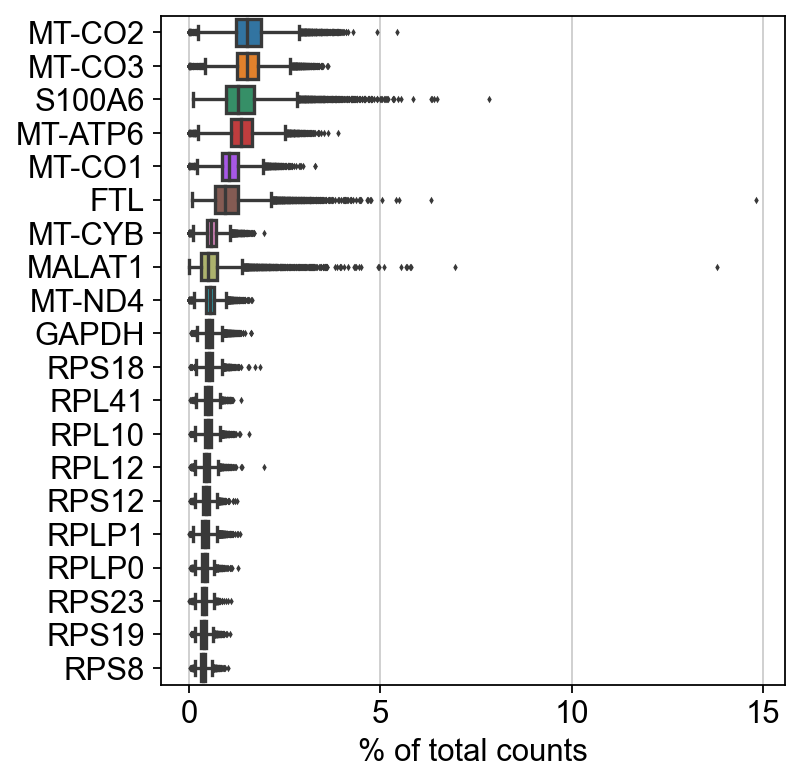

In [17]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [18]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 7143 genes that are detected in less than 3 cells


In [19]:
adata.shape

(23540, 29458)

In [20]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

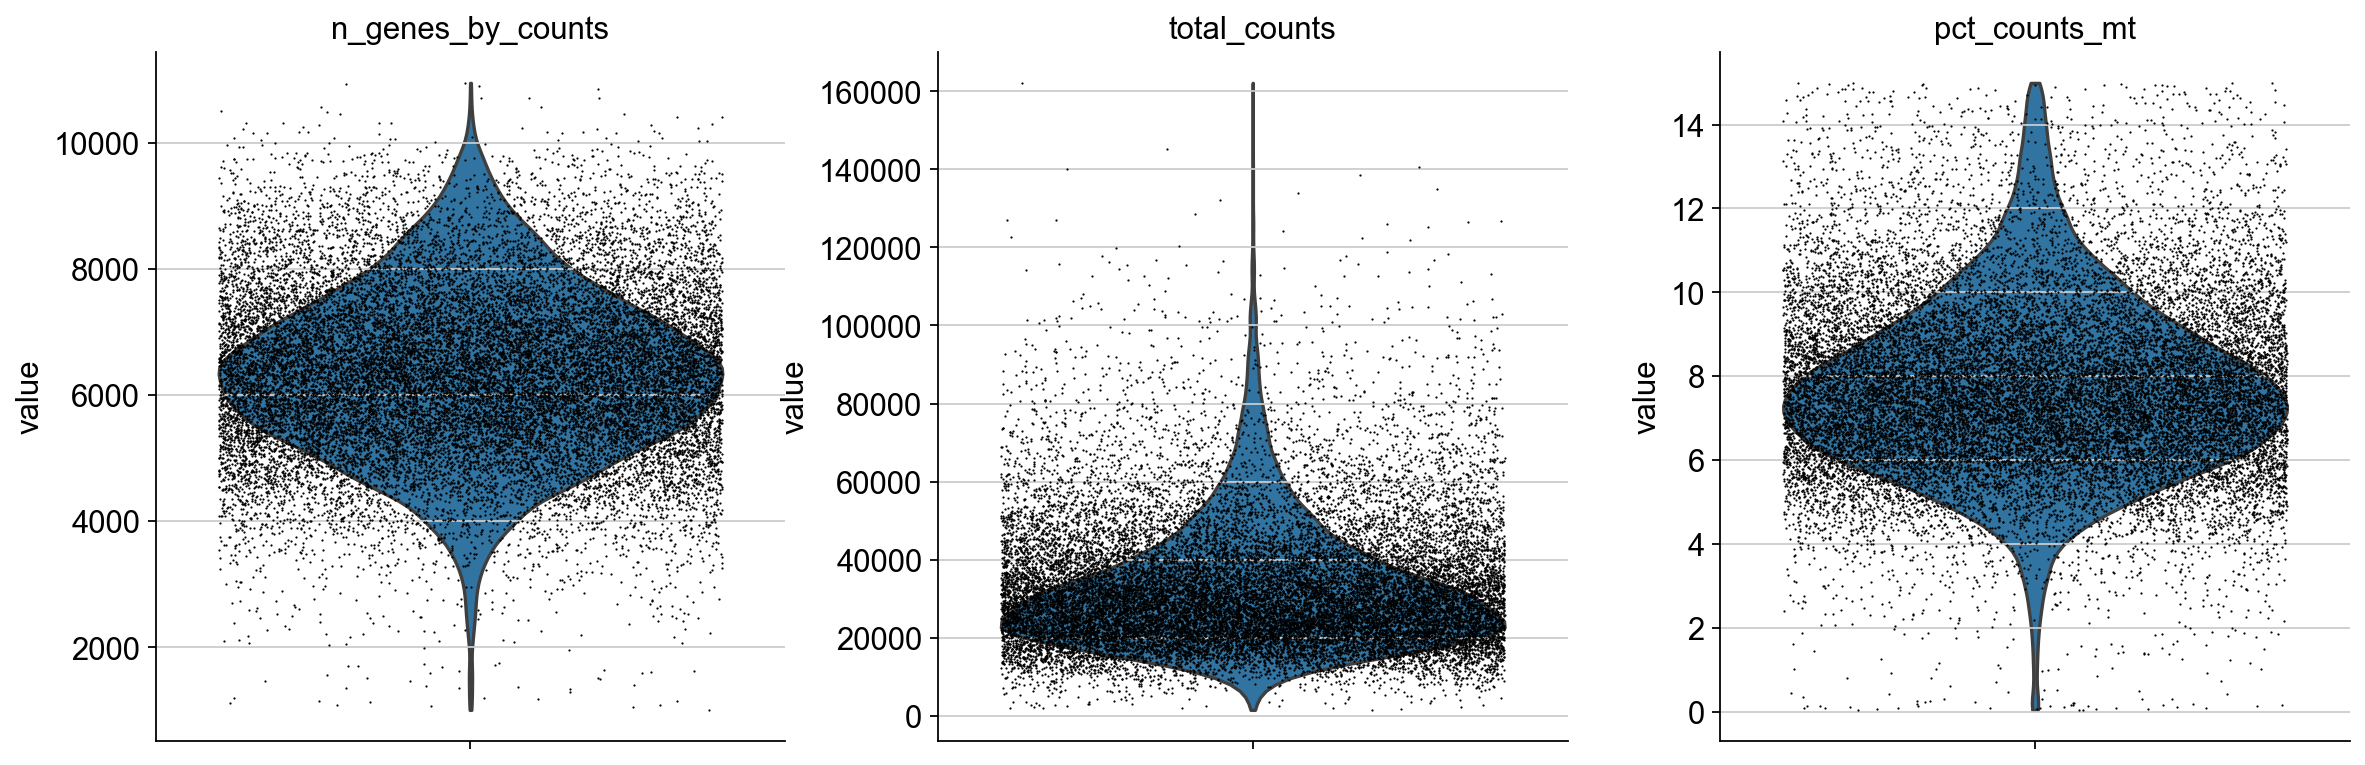

In [21]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

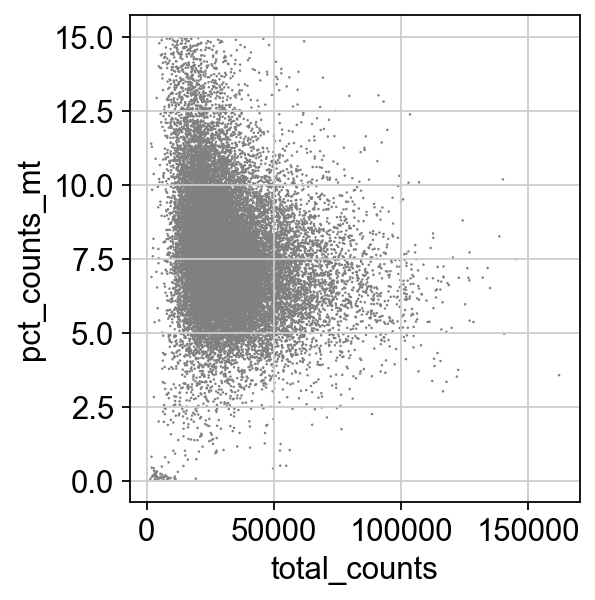

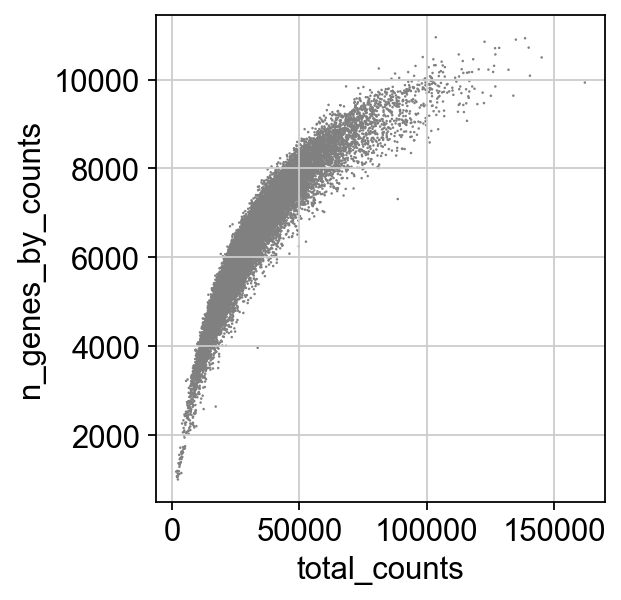

In [22]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt',)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [23]:
adata = adata[adata.obs.pct_counts_mt < 15, :]

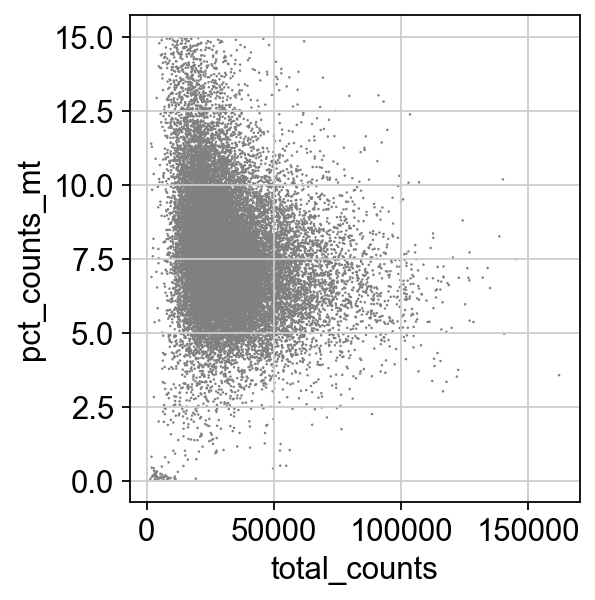

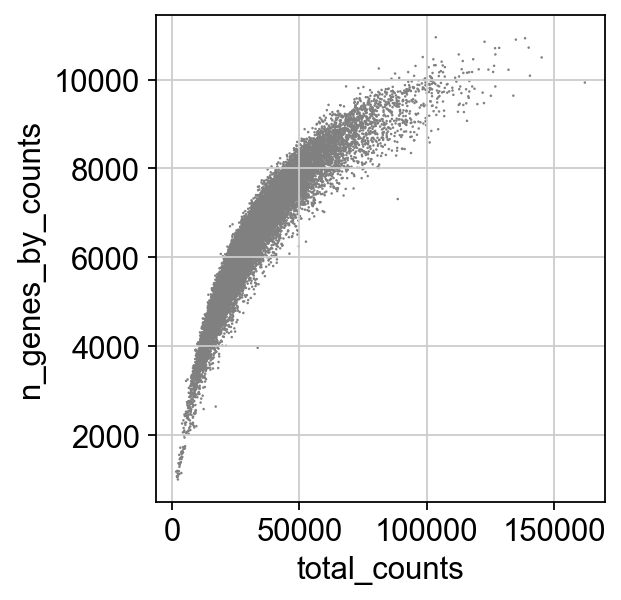

In [24]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt',)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [25]:
adata.shape

(23540, 29458)

In [26]:
### remove control cells from adata
cells_to_keep = [cell for cell, cell_type in zip(adata.obs.index, adata.obs['guide']) if not cell_type.startswith('TuD_NC')]
adata = adata[cells_to_keep,:]

82.56410256410257% of cells remain after guides with < 10 cells are removed


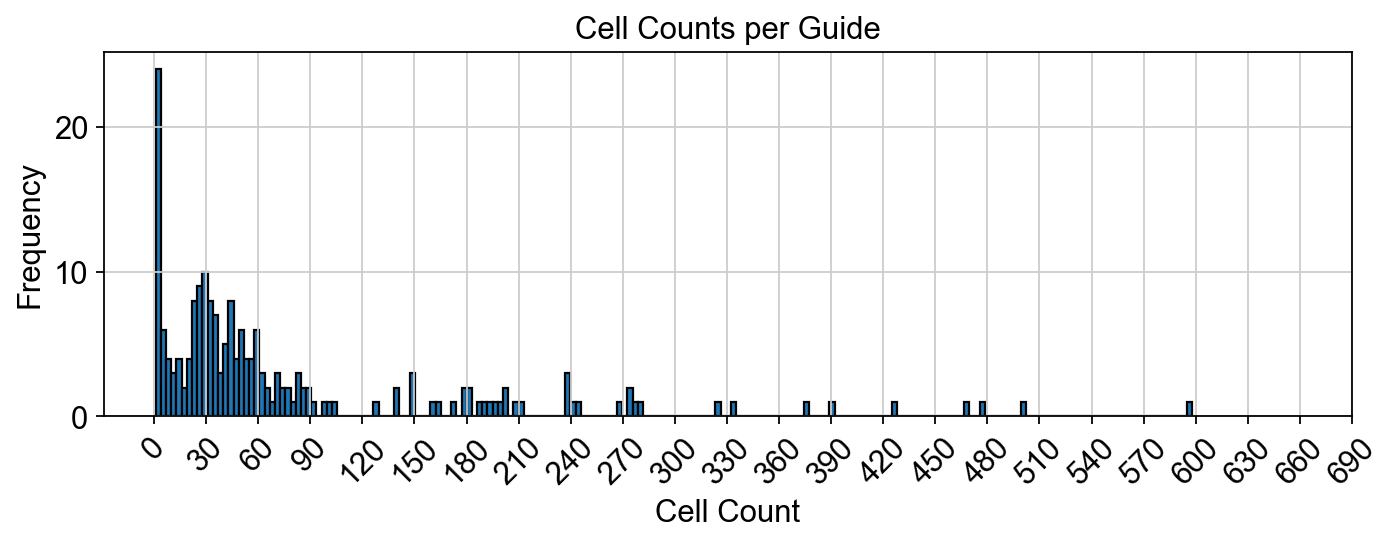

In [27]:
## get cell counts per guide
from collections import Counter
cell_counts = list(Counter(adata.obs['guide']).values())

## count % of guides >= cell_cutoff
print(f'{100*sum([1 for val in cell_counts if val >= cell_cutoff])/len(cell_counts)}% of cells remain after guides with < {cell_cutoff} cells are removed')

import matplotlib.pyplot as plt

# Create histogram
plt.hist(cell_counts, bins=200, edgecolor='black')

# Add labels and title
plt.xlabel('Cell Count')
plt.ylabel('Frequency')
plt.title('Cell Counts per Guide')

plt.xticks(np.arange(0, 700, 30), rotation=45)

## increase width of the plot
plt.gcf().set_size_inches(10, 3)
# Display the histogram
plt.show()


In [28]:
## remove guides with cell counts < cell_cutoff
guide_counts = adata.obs['guide'].value_counts()
kept_guides = guide_counts[guide_counts >= cell_cutoff]
adata = adata[adata.obs['guide'].isin(kept_guides.index.tolist()),:]

In [30]:
## sample cell_cutoff number of cells from all remaining guides to equally represent guides and cut down on number of cells for model to process
import random
random.seed(123)
adata = adata[adata.obs.groupby('guide').apply(lambda x: x.sample(cell_cutoff)).index.get_level_values(1),:]

In [29]:
adata.shape

(15680, 29458)

In [ ]:
mini_batch = adata.shape[0]

In [30]:
adata.obs

,sample,barcode,guide,lor,pvalue,adj_pvalue,max_umi,n_umi,m_umi,v_umi,log_max_umi,log_n_umi,log_m_umi,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
tRF_1:AAACCCACATATACCG-1,tRF_1,AAACCCACATATACCG,tRF_Arg_ACG_2,7.473168,2.865581e-322,1.452806e-315,182.0,214.0,0.977169,151.260944,2.260071,2.330414,-0.010030,7088,7087,35202.0,2216.0,6.295097
tRF_1:AAACCCACATGACGGA-1,tRF_1,AAACCCACATGACGGA,tRF_Arg_ACG_2,1.160519,2.865581e-322,1.452806e-315,214.0,372.0,1.698630,237.780319,2.330414,2.570543,0.230099,7152,7152,38018.0,2597.0,6.830975
tRF_1:AAACCCAGTTATCTTC-1,tRF_1,AAACCCAGTTATCTTC,tRF_Glu_CTC_2,4.656560,7.086097e-135,3.592545e-128,69.0,88.0,0.401826,21.984584,1.838849,1.944483,-0.395961,6690,6690,28003.0,1853.0,6.617148
tRF_1:AAACCCATCGTGGGAA-1,tRF_1,AAACCCATCGTGGGAA,tRF_Lys_TTT_2,2.024558,2.865581e-322,1.452806e-315,272.0,379.0,1.730594,362.326170,2.434569,2.578639,0.238195,6135,6135,28249.0,1149.0,4.067400
tRF_1:AAACGAAAGTCTCTGA-1,tRF_1,AAACGAAAGTCTCTGA,tRF_Ala_TGC.AGC_6,2.227511,6.138288e-15,3.112020e-08,8.0,9.0,0.041096,0.296469,0.903090,0.954243,-1.386202,4025,4025,12857.0,715.0,5.561173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tRF_3:TTTGTTGCAATTAGGA-1,tRF_3,TTTGTTGCAATTAGGA,tRF_Cys.Ala_GCA.AGC_3,1.503047,3.938314e-160,1.541961e-153,105.0,247.0,1.127854,83.974404,2.021189,2.392697,0.052253,5940,5940,26850.0,1681.0,6.260708
tRF_3:TTTGTTGCACTCTGCT-1,tRF_3,TTTGTTGCACTCTGCT,tRF_Gln_CTG_2,2.443993,6.692845e-167,2.620437e-160,101.0,159.0,0.726027,51.713586,2.004321,2.201397,-0.139047,5075,5075,17245.0,1451.0,8.414033
tRF_3:TTTGTTGGTCACGCTG-1,tRF_3,TTTGTTGGTCACGCTG,tRF_Gly_TCC_4,4.035205,8.878960e-54,3.476363e-47,32.0,35.0,0.159817,4.685350,1.505150,1.544068,-0.796376,8543,8543,53590.0,5888.0,10.987124
tRF_3:TTTGTTGTCAACCGAT-1,tRF_3,TTTGTTGTCAACCGAT,tRNA-Asn-GTT-8-1.rh,5.613436,2.188911e-183,8.570205e-177,67.0,80.0,0.365297,20.535671,1.826075,1.903090,-0.437354,8271,8271,46554.0,3616.0,7.767324


In [31]:
### pertubation annotation to add to each cell
one_hot_df = pd.get_dummies(adata.obs["guide"])

In [32]:
one_hot_df

,tRF_Ala_AGC_2,tRF_Ala_CGC.AGC.TGC_5,tRF_Ala_CGC_2,tRF_Ala_TGC.AGC_6,tRF_Ala_TGC_2,tRF_Arg_ACG_2,tRF_Arg_CCG.CCT_3,tRF_Arg_CCT_2,tRF_Arg_CCT_3,tRF_Arg_TCG.CCG_2,...,tRNA-Tyr-GTA-2-1.lh,tRNA-Val-AAC-3-1.2t,tRNA-Val-AAC-3-1.rh,tRNA-Val-CAC-2-1.rh,tRNA-Val-CAC-3-1.rh,tRNA-Val-CAC-6-1.rh,tRNA-Val-CAC-(6)1-1.rh,tRNA-Val-TAC-(2)1-1.2t,tRNA-iMet-CAT-(8)1-1.2t,tRNA-iMet-CAT-(8)1-1.rh
tRF_1:AAACCCACATATACCG-1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tRF_1:AAACCCACATGACGGA-1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tRF_1:AAACCCAGTTATCTTC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tRF_1:AAACCCATCGTGGGAA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tRF_1:AAACGAAAGTCTCTGA-1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tRF_3:TTTGTTGCAATTAGGA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tRF_3:TTTGTTGCACTCTGCT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tRF_3:TTTGTTGGTCACGCTG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tRF_3:TTTGTTGTCAACCGAT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
## add the gene annotation for the first layer
## the first layer is connected to the second in a way such that reflects pathways
## RBP_gene_df is the gene connections (first layer) to TFs (second layer) gmt file

In [34]:
import scipy.sparse as sp_sparse
import tables
from itertools import chain
from model import loss_function
from model import VAE
import numpy as np
import os
import pandas as pd
import torch
from gseapy import read_gmt
from datetime import datetime


In [35]:
gene_set_annot = pd.read_csv('/home/ssobti/projects/mir_tud/uploaded_data/tRF_mave_genesets/kegg_gene_sets.csv', sep=',')

In [36]:
gene_set_annot = gene_set_annot.loc[:, ['gs_name', 'gene_symbol']]
gene_set_annot

,gs_name,gene_symbol
0,KEGG_ABC_TRANSPORTERS,ABCA1
1,KEGG_ABC_TRANSPORTERS,ABCA10
2,KEGG_ABC_TRANSPORTERS,ABCA12
3,KEGG_ABC_TRANSPORTERS,ABCA13
4,KEGG_ABC_TRANSPORTERS,ABCA2
...,...,...
16278,KEGG_WNT_SIGNALING_PATHWAY,WNT8A
16279,KEGG_WNT_SIGNALING_PATHWAY,WNT8B
16280,KEGG_WNT_SIGNALING_PATHWAY,WNT9A
16281,KEGG_WNT_SIGNALING_PATHWAY,WNT9B


In [37]:
gene_sets = list(set(gene_set_annot.loc[:,'gs_name']))

In [38]:
gmt_file = {}
for idx, gene_set in enumerate(gene_sets):
    targets = gene_set_annot.loc[gene_set == gene_set_annot.loc[:, 'gs_name'], 'gene_symbol']
    gmt_file[gene_set] = list(targets)

In [39]:
### creating a matrix that links gene sets (columns) to master regulators (rows) via 0/1 annotation
gmt_file = pd.Series(gmt_file).str.join('|')
gmt_file = gmt_file.str.get_dummies()
gmt_file

,A2M,A4GALT,AACS,AADAT,AANAT,AARS1,AARS2,AASDH,AASDHPPT,AASS,...,ZBTB16,ZBTB17,ZCCHC7,ZFYVE16,ZFYVE9,ZIC2,ZMAT2,ZMAT3,ZNF274,ZYX
KEGG_ALPHA_LINOLENIC_ACID_METABOLISM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KEGG_ABC_TRANSPORTERS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KEGG_PURINE_METABOLISM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KEGG_GAP_JUNCTION,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KEGG_PATHWAYS_IN_CANCER,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KEGG_MATURITY_ONSET_DIABETES_OF_THE_YOUNG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KEGG_GLYCOSAMINOGLYCAN_DEGRADATION,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KEGG_SMALL_CELL_LUNG_CANCER,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KEGG_PENTOSE_AND_GLUCURONATE_INTERCONVERSIONS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
## remove genes not in intersection bw expression matrix and gene_set annotation df
a = set(gmt_file.columns.to_list())
b = set(adata.var.index.to_list())

intersecting_genes = list(a.intersection(b))
print('Genes in annotated gene sets', len(a))
print('Genes in expression matrix', len(b))
print('Union', len(a.union(b)))
print('Intersecting genes kept', len(a.intersection(b)))

adata = adata[:, intersecting_genes]
gmt_file = gmt_file.loc[:, intersecting_genes]

Genes in annotated gene sets 5245
Genes in expression matrix 29458
Union 30162
Intersecting genes kept 4541


In [41]:
gmtmat_df = gmt_file.transpose()
gmtmat_df

,KEGG_ALPHA_LINOLENIC_ACID_METABOLISM,KEGG_ABC_TRANSPORTERS,KEGG_PURINE_METABOLISM,KEGG_GAP_JUNCTION,KEGG_PATHWAYS_IN_CANCER,KEGG_PANTOTHENATE_AND_COA_BIOSYNTHESIS,KEGG_ARRHYTHMOGENIC_RIGHT_VENTRICULAR_CARDIOMYOPATHY_ARVC,KEGG_ETHER_LIPID_METABOLISM,KEGG_PARKINSONS_DISEASE,KEGG_PRIMARY_IMMUNODEFICIENCY,...,KEGG_AMINO_SUGAR_AND_NUCLEOTIDE_SUGAR_METABOLISM,KEGG_ADHERENS_JUNCTION,KEGG_OXIDATIVE_PHOSPHORYLATION,KEGG_PROTEIN_EXPORT,KEGG_ASCORBATE_AND_ALDARATE_METABOLISM,KEGG_MATURITY_ONSET_DIABETES_OF_THE_YOUNG,KEGG_GLYCOSAMINOGLYCAN_DEGRADATION,KEGG_SMALL_CELL_LUNG_CANCER,KEGG_PENTOSE_AND_GLUCURONATE_INTERCONVERSIONS,KEGG_EPITHELIAL_CELL_SIGNALING_IN_HELICOBACTER_PYLORI_INFECTION
DHDDS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GRID1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NR1D1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NDUFB7,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
SMURF1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAS1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PIK3R4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR2T4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MAP3K12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
gmtmat = gmtmat_df.to_numpy()
gmtmat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [43]:
device='cpu'

In [44]:
gmttensor = torch.from_numpy(
            np.transpose(gmtmat)).to(device).long()
gmttensor

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [45]:
## this function tells you how many paramters are in a model
def get_n_params(model):
    pp = 0
    for p in list(model.parameters()):
        nn = 1
        for s in list(p.size()):
            nn = nn * s
        pp += nn
    return pp

# Twin Model

In [46]:
import random
samps=random.sample(list(adata.obs.guide.unique()),2)
samps

['tRNA-Arg-TCT-(2)3-1.2t', 'tRF_Glu_TTC_2']

In [47]:
adata.obs.index

Index(['tRF_1:AAACCCACATATACCG-1', 'tRF_1:AAACCCACATGACGGA-1',
       'tRF_1:AAACCCAGTTATCTTC-1', 'tRF_1:AAACCCATCGTGGGAA-1',
       'tRF_1:AAACGAAAGTCTCTGA-1', 'tRF_1:AAACGAAGTAGGACTG-1',
       'tRF_1:AAACGAAGTATGATCC-1', 'tRF_1:AAACGCTCAAGCACAG-1',
       'tRF_1:AAACGCTCACACGCCA-1', 'tRF_1:AAACGCTCAGCTTCCT-1',
       ...
       'tRF_3:TTTGGAGGTCGATTAC-1', 'tRF_3:TTTGGAGGTGGTCTAT-1',
       'tRF_3:TTTGGAGTCTTCGCTG-1', 'tRF_3:TTTGGTTTCCCTCGTA-1',
       'tRF_3:TTTGTTGAGTGCCGAA-1', 'tRF_3:TTTGTTGCAATTAGGA-1',
       'tRF_3:TTTGTTGCACTCTGCT-1', 'tRF_3:TTTGTTGGTCACGCTG-1',
       'tRF_3:TTTGTTGTCAACCGAT-1', 'tRF_3:TTTGTTGTCAAGTGTC-1'],
      dtype='object', length=15680)

In [48]:
ct_cbc_dict = {}
cbc_ct_dict = {}
for ct in list(adata.obs.guide.unique()):
    ct_cbc_dict[ct] = adata.obs.query(f'guide==\"{ct}\"').index.tolist()
    for cbc in ct_cbc_dict[ct]:
        cbc_ct_dict[cbc] = ct
list(ct_cbc_dict.items())[1]

('tRF_Glu_CTC_2',
 ['tRF_1:AAACCCAGTTATCTTC-1',
  'tRF_1:AACCAACAGGTAAAGG-1',
  'tRF_1:ACTTTCACAACGGTAG-1',
  'tRF_1:ACTTTGTTCCTACACC-1',
  'tRF_1:AGCTCAAAGTGGATTA-1',
  'tRF_1:AGCTTCCGTCGTTGCG-1',
  'tRF_1:AGGTTGTCAAGAGTTA-1',
  'tRF_1:AGTGCCGGTCAGCGTC-1',
  'tRF_1:ATGGAGGCACAGCTGC-1',
  'tRF_1:ATTACTCAGACCCGCT-1',
  'tRF_1:ATTATCCGTGCTGCAC-1',
  'tRF_1:ATTTACCAGTTAACAG-1',
  'tRF_1:CACACAACAAATGAGT-1',
  'tRF_1:CACCAAAGTCTCGGGT-1',
  'tRF_1:CACGTGGGTAAGATCA-1',
  'tRF_1:CACTAAGGTAGCGAGT-1',
  'tRF_1:CATCGTCGTACACGCC-1',
  'tRF_1:CCACGTTAGTTCCGGC-1',
  'tRF_1:CCCGAAGGTTGGATCT-1',
  'tRF_1:CCGGTGAGTACCCGAC-1',
  'tRF_1:CGACAGCGTTAAGCAA-1',
  'tRF_1:CGTAAGTGTGGAGGTT-1',
  'tRF_1:CTACCTGGTGATATAG-1',
  'tRF_1:CTAGGTATCTAACACG-1',
  'tRF_1:CTGAATGTCTGAATGC-1',
  'tRF_1:CTGAGCGGTCCATACA-1',
  'tRF_1:GAATCGTCAATGTCAC-1',
  'tRF_1:GACCTTCGTGAGTTGG-1',
  'tRF_1:GACGCTGCACGCTATA-1',
  'tRF_1:GACTCAACAGGTGGAT-1',
  'tRF_1:GATAGAATCGCAGATT-1',
  'tRF_1:GATGTTGAGCCTCATA-1',
  'tRF_1:GATTTCTAGGTCG

In [49]:
list(cbc_ct_dict.items())[1]

('tRF_1:AAACCCACATGACGGA-1', 'tRF_Arg_ACG_2')

In [50]:
adata.X.toarray().shape

(15680, 4541)

In [51]:
adata.var.shape

(4541, 7)

In [52]:
## this converts the expression matrix to a dictionary 
## where each cell/row of matrix is now a 'key' with associated gene expression values

cbc_arr_dict = {}
for cbc, arr in zip(adata.obs.index.tolist(), adata.X.toarray()):
    cbc_arr_dict[cbc] = arr.copy()
list(cbc_arr_dict.items())[1]

('tRF_1:AAACCCACATGACGGA-1',
 array([2., 0., 0., ..., 0., 0., 0.], dtype=float32))

In [53]:
## this converts the cell barcode to guide annotation df to a dictionary 
one_hot_dict = one_hot_df.T.to_dict(orient='list')
list(one_hot_dict.keys())[0]

'tRF_1:AAACCCACATATACCG-1'

In [54]:
numlvs = latent_vars
vae = VAE(adata.shape[1],  # num genes
              gmttensor, #gmttensor
              len(set(adata.obs["guide"])), #number of cell types
              0,  # batch
              0,  # labels
              gmtmat.shape[1],  # hiddensize
              numlvs)

n_params = get_n_params(vae)
print("VAE has {} parameters".format(n_params))
vae.to(device)

VAE has 4250713 parameters


VAE(
  (z_encoder): Encoder(
    (encoder): FCLayersEncoder(
      (fc_layers): Sequential(
        (Layer_0): Sequential(
          (0): CustomConnected()
          (1): BatchNorm1d(186, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=186, out_features=10, bias=True)
    (var_encoder): Linear(in_features=186, out_features=10, bias=True)
  )
  (ctpred_linear): Linear(in_features=10, out_features=161, bias=True)
  (ctpred_activation): ReLU()
  (l_encoder): Encoder(
    (encoder): FCLayersEncoder(
      (fc_layers): Sequential(
        (Layer_0): Sequential(
          (0): CustomConnected()
          (1): BatchNorm1d(186, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in

In [55]:
optimizer = torch.optim.Adam(
        vae.parameters(), lr=learning_rate)

SAMPLE_IDXS = adata.shape[0]

In [56]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
from torchvision import transforms

class tripletDataset(Dataset):
    def __init__(self, cbc_list, ct_list, ct_cbc_dict, cbc_ct_dict, cbc_arr_dict, one_hot_dict):
        self.cbc_list = cbc_list
        self.ct_list = ct_list
        self.ct_cbc_dict = ct_cbc_dict
        self.cbc_ct_dict = cbc_ct_dict
        self.cbc_arr_dict = cbc_arr_dict
        self.one_hot_dict = one_hot_dict
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        cbc_anchor = self.cbc_list[idx]
        ct_anchor = self.cbc_ct_dict[cbc_anchor]

        #for negative, pick two random cell types, in case the 1st one turned out to be the same as the anchor's cell type
        ct1, ct2 = random.sample(self.ct_list, 2) 
        ct_neg = ct1
        if ct1==ct_anchor:
            ct_neg = ct2
        
        #for positive, pick two cell barcodes, in case the 1st one turned out to be the anchor itself
        cbc1, cbc2 = random.sample(self.ct_cbc_dict[ct_anchor], 2)
        cbc_pos = cbc1
        if cbc1==cbc_anchor:
            cbc_pos = cbc2
        
        cbc_neg = random.choice(self.ct_cbc_dict[ct_neg])
        
        ohot_arr = np.array(self.one_hot_dict[cbc_anchor])
                
        return (torch.from_numpy(cbc_arr_dict[cbc_anchor].astype(np.float32)),
                torch.from_numpy(cbc_arr_dict[cbc_pos].astype(np.float32)),
                torch.from_numpy(cbc_arr_dict[cbc_neg].astype(np.float32)),
                torch.from_numpy(ohot_arr.astype(np.float32)), cbc_anchor, idx)
    
    def __len__(self):
        return len(self.cbc_list)


In [57]:
import random
import math

In [58]:
len(adata.obs.index.tolist())

15680

In [59]:
random.seed(5)
randomized_cbc_list = random.sample(adata.obs.index.tolist(), math.ceil(len(adata.obs.index.tolist())*0.8))

In [60]:
test_cells = list(set(adata.obs.index.tolist()).difference(randomized_cbc_list))

In [61]:
len(randomized_cbc_list)

12544

In [62]:
def get_key(val, dictionary):
    for key, value in dictionary.items():
        if val in value:
            return key
 
    return "key doesn't exist"

In [63]:
ct_cbc_dict_edited = ct_cbc_dict.copy()

In [64]:
test_cells_set = set(test_cells)
for key, vals in ct_cbc_dict_edited.items():
        ct_cbc_dict_edited[key] = list(set(vals).difference(test_cells_set))

In [65]:
get_key(test_cells[0], ct_cbc_dict_edited) ## should not find a key since these cells should be deleted from the dictionary

"key doesn't exist"

In [66]:
cbc_ct_dict_edited = cbc_ct_dict.copy()

In [67]:
for key in cbc_ct_dict:
    if key in test_cells:
        del cbc_ct_dict_edited[key]

In [68]:
from itertools import islice
dict(islice(cbc_ct_dict.items(), 0, 2))

{'tRF_1:AAACCCACATATACCG-1': 'tRF_Arg_ACG_2',
 'tRF_1:AAACCCACATGACGGA-1': 'tRF_Arg_ACG_2'}

In [69]:
len(list(adata.obs.guide.unique()))

161

In [70]:
len(set(cbc_ct_dict_edited.values()))

161

In [71]:
cbc_arr_dict_edited = cbc_arr_dict.copy()

In [72]:
for key in cbc_arr_dict:
    if key in test_cells:
        del cbc_arr_dict_edited[key]

In [73]:
one_hot_dict_edited = one_hot_dict.copy()

In [74]:
for key in one_hot_dict:
    if key in test_cells:
        del one_hot_dict_edited[key]

In [75]:
triplet_loader = DataLoader(tripletDataset(randomized_cbc_list, list(set(cbc_ct_dict_edited.values())), ct_cbc_dict_edited, cbc_ct_dict_edited, cbc_arr_dict_edited, one_hot_dict_edited), batch_size=mini_batch, shuffle=True)

In [76]:
comparison_array = adata[randomized_cbc_list,:].X.toarray()

In [77]:
comparison_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [78]:
adata.X.toarray().shape[0]

15680

In [79]:
int(comparison_array.shape[0] / triplet_loader.batch_size)

6

In [83]:
MINIBATCH = mini_batch
MAXEPOCH = max_epoch
loss_scalers = [10000, 1, 1, 10000] #[recon_loss, KLD_loss, classification_loss, triplet_loss]
predict_celltypes = True
num_celltypes = len(set(cbc_ct_dict_edited.values()))
from scipy.stats import pearsonr
arrayed_data = adata[randomized_cbc_list,:].X.toarray()
R_tbl = pd.DataFrame(0, index=range(MAXEPOCH), columns=range(adata[randomized_cbc_list,:].shape[0]))

def train_model(vae, optimizer, data_loader, MAXEPOCH, expar, logdir,
                modelpath, chkpath, loss_scalers, predict_celltypes):
    criterion_class = torch.nn.CrossEntropyLoss()
    time_str = str(datetime.now())
    time_str = time_str.replace(" ", "_")
    time_str = time_str.replace(":", "0")
    logpath = os.path.join(
        logdir,
        weighting_scheme + "training.log.{}".format(time_str))
    loglink = open(logpath, "w")
    header = ["Epoch", "Training.Loss", "Recon_Loss", "KLD_Loss", "Classification_Loss", "Triplet_Loss", "MiniBatch.ID", "Time.Stamp"]
    loglink.write("\t".join(header) + "\n")
    loglink.close()
    TOTBATCHIDX = int(expar.shape[0] / data_loader.batch_size)
    
    for epoch in range(MAXEPOCH):
        running_loss = 0
        for idxbatch, batch in enumerate(data_loader):
            anchor, pos, neg, ohot, barcds, ids = [x.to(device).float() if ind < 4 else x for ind,x in enumerate(batch)]
            local_l_mean = np.mean(
                np.apply_along_axis(
                    np.sum, 1, anchor.detach().numpy()))
            local_l_var = np.var(
                np.apply_along_axis(
                    np.sum, 1, anchor.detach().numpy()))
            outdict_anchor = vae(anchor)
            outdict_pos = vae(pos)
            outdict_neg = vae(neg)

            ct_pred = outdict_anchor["ctpred"]
            loss_1, loss_2 = loss_function(
                outdict_anchor['qz_m'], outdict_anchor['qz_v'], anchor,
                outdict_anchor['px_rate'], outdict_anchor['px_r'],
                outdict_anchor['px_dropout'], outdict_anchor['ql_m'],
                outdict_anchor['ql_v'], True,
                local_l_mean, local_l_var)
            reconst = outdict_anchor['px_scale'].cpu().detach().numpy()
            Rs = []
            arrayed_data_ordered = arrayed_data[ids.tolist(),:]
            for i in range(len(reconst)):
                Rs.append(pearsonr(arrayed_data_ordered[i,:], reconst[i,:])[0])
            R_tbl.iloc[epoch, ids.tolist()] = Rs
            loss_1 = torch.mean(loss_1)
            loss_2 = torch.mean(loss_2)
            optimizer.zero_grad()
            if predict_celltypes:
                one_hot_temp = torch.max(ohot, 1)[1].to(device).long()
                loss_3 = criterion_class(ct_pred, one_hot_temp)
            else:
                loss_3 = 0

            distance_positive = (outdict_anchor['qz_m'] - outdict_pos['qz_m']).pow(2).sum(1)  # .pow(.5)
            distance_negative = (outdict_anchor['qz_m'] - outdict_neg['qz_m']).pow(2).sum(1)  # .pow(.5)
            losses = F.relu(distance_positive - distance_negative + 1.0)
            loss_4 = losses.mean()

            if idxbatch == 0:
                print(loss_1, loss_2, loss_3, loss_4)
            if idxbatch == -1 and epoch % 25 == 0:
                loss_scalers = np.array(
                    [loss_1.detach().cpu().numpy(),
                     loss_2.detach().cpu().numpy(),
                     loss_3.detach().cpu().numpy()])
                if np.min(loss_scalers) < 0:
                    if loss_2 < 0:
                        loss_2 = loss_2 * -1
                    else:
                        raise ValueError("One of the losses are negative")
                    print(loss_1)
                    print(loss_2)
                    print(loss_3)
                loss_scalers = loss_scalers / np.min(loss_scalers)
            loss = (loss_1 / torch.tensor(loss_scalers[0])) + (
                loss_2 / torch.tensor(loss_scalers[1])) + (
                loss_3 / torch.tensor(loss_scalers[2])) + (
                loss_4 / torch.tensor(loss_scalers[3]))
            if idxbatch == 0:
                print(loss)
            if torch.isnan(loss):
                print("Losses: {} {} {}".format(loss_1, loss_2, loss_3, loss_4))
                raise ValueError("NA occured in loss")
            # print(loss)
            loss.backward()
            optimizer.step()
            running_loss += loss
            del anchor, pos, neg, outdict_anchor, outdict_pos, outdict_neg
            # del one_hot_temp
            torch.cuda.empty_cache()
        cur_loss = running_loss / TOTBATCHIDX
        print("Epoch {}, Loss {} ({} {} {} {}) at {}".format(
            epoch, cur_loss.item(), loss_1, loss_2, loss_3, loss_4, datetime.now()))

        with open(logpath, "a+") as loglink:
            adlist = [str(epoch), str(cur_loss.item()), str(loss_1), str(loss_2), str(loss_3), str(loss_4),
                      str(idxbatch), str(datetime.now())]
            loglink.write("\t".join(adlist) + "\n")
        if epoch % 50 == 0:
            checkpoint = {
                'model': vae.state_dict(),
                'optimizer': optimizer.state_dict()
            }
            for eachpath in [modelpath, chkpath]:
                torch.save(checkpoint, eachpath)
    return vae

In [84]:
## this model was run separately as a separate notebook in the background which ended at this cell  
## To reload it, the data structure skeleton of the model has to be rebuilt by running the MAXEPOCH at ~ 1 or 2
## in order for you to be able to load the model trained for 400 epochs
vae = train_model(
                vae, optimizer, triplet_loader, MAXEPOCH,
                comparison_array, '/home/ssobti/projects/mir_tud/output_data/mave_output/mave_trblsht/tRF/parameter_optimization/' + weighting_scheme_folder + '/logs',
                '/home/ssobti/projects/mir_tud/output_data/mave_output/mave_trblsht/tRF/parameter_optimization/' + weighting_scheme_folder + '/models/' + weighting_scheme + 'model.pt', '/home/ssobti/projects/mir_tud/output_data/mave_output/mave_trblsht/tRF/parameter_optimization/' + weighting_scheme_folder + '/ckpt/' + weighting_scheme + 'ckpt.pt',
                loss_scalers, predict_celltypes)

tensor(5423.9604, grad_fn=<MeanBackward0>) tensor(0.0300, grad_fn=<MeanBackward0>) tensor(5.0351, grad_fn=<NllLossBackward0>) tensor(0.9995, grad_fn=<MeanBackward0>)
tensor(5.6076, grad_fn=<AddBackward0>)
Epoch 0, Loss 6.539880275726318 (5404.87744140625 0.026292311027646065 5.029196262359619 1.0003238916397095) at 2024-04-09 12:54:28.849285


In [85]:
def apply_model(vae, expar, numlvs, MINIBATCH):
    tf_activation = None
    weight_arr = torch.mul(
         vae.z_encoder.encoder.fc_layers.Layer_0[0].weights,
         vae.z_encoder.encoder.connections).detach().cpu().numpy()
    bias_arr = vae.z_encoder.encoder.fc_layers.Layer_0[0].bias.detach().cpu().numpy()
    reconst = np.zeros(expar.shape)
    mumat = np.zeros((expar.shape[0], numlvs))
    logvarmat = np.zeros((expar.shape[0], numlvs))
    TOTBATCHIDX = int(expar.shape[0] / MINIBATCH)
    for idxbatch in range(TOTBATCHIDX):
        idxbatch_st = idxbatch * MINIBATCH
        idxbatch_end = (idxbatch + 1) * MINIBATCH
        train1 = torch.from_numpy(
            expar[idxbatch_st:idxbatch_end, :]).to(device).float()
        outdict = vae(train1)
        reconst[idxbatch_st:idxbatch_end, :] = \
            outdict["px_scale"].cpu().detach().numpy()
        mumat[idxbatch_st:idxbatch_end, :] = \
            outdict["qz_m"].cpu().detach().numpy()
        logvarmat[idxbatch_st:idxbatch_end, :] = \
            outdict["qz_v"].cpu().detach().numpy()
        if idxbatch % 100 == 0:
            print("Applied on {}/{}".format(idxbatch, TOTBATCHIDX))
    # Multiply the expar with weight_arr
    tf_activation = np.matmul(
         expar, np.transpose(weight_arr))
    tf_activation = tf_activation + bias_arr
    return reconst, mumat, logvarmat, tf_activation

In [86]:
reconst, mumat, logvarmat, rbp_act = apply_model(
                vae, comparison_array, numlvs, MINIBATCH)

Applied on 0/6


In [87]:
mudf = pd.DataFrame(mumat)
mudf.columns = ["LV.mu.{}".format(each)
                            for each in range(numlvs)]

mudf.index = np.array(adata[randomized_cbc_list,:].obs.index, dtype="|U64")
mudf.head()

,LV.mu.0,LV.mu.1,LV.mu.2,LV.mu.3,LV.mu.4,LV.mu.5,LV.mu.6,LV.mu.7,LV.mu.8,LV.mu.9
tRF_2:TGTCCTGGTTGACTGT-1,0.024266,0.032865,-0.065809,-0.125615,0.059102,0.060536,-0.020739,-0.018189,0.084462,0.060012
tRF_1:TATCGCCGTACAATAG-1,0.070415,0.264708,-0.009986,-0.105533,0.046750,0.005879,-0.030709,-0.011926,0.049366,0.056697
tRF_3:CATGCGGAGACCATTC-1,-0.003631,-0.036669,0.099795,-0.077380,-0.008913,0.005895,0.017949,0.011423,-0.087628,0.018139
tRF_2:ACCTACCTCGTTAGAC-1,0.062837,-0.108785,0.026834,0.017703,0.019692,0.003337,0.009378,-0.008418,0.030879,0.019073
tRF_3:CTTTCAAGTCATTCCC-1,0.058515,-0.005342,-0.015943,-0.051947,-0.009042,0.032582,-0.026785,0.053153,0.086092,0.027061


In [88]:
mudf.to_csv('/home/ssobti/projects/mir_tud/output_data/mave_output/mave_trblsht/tRF/parameter_optimization/' + weighting_scheme_folder + '/' + weighting_scheme + 'scMAVE_mu-matrix.tsv.gz',
                compression="gzip", sep="\t")

In [89]:
import umap
import seaborn as sns
from matplotlib import pyplot as plt
mumat = np.array(mudf.iloc[:, :numlvs])
reducer = umap.UMAP(n_neighbors=10, min_dist=0.45)
embedding = reducer.fit_transform(mumat)
umap_output = pd.DataFrame(embedding)
umap_output.columns = ["UMAP1", "UMAP2"]
umap_output["guide"] = list(adata[randomized_cbc_list,:].obs["guide"])
umap_output.index = mudf.index
umap_output.head()

,UMAP1,UMAP2,guide
tRF_2:TGTCCTGGTTGACTGT-1,10.023365,9.654814,tRF_Glu_TTC_4
tRF_1:TATCGCCGTACAATAG-1,11.749619,9.634947,tRF_Thr_TGT_3
tRF_3:CATGCGGAGACCATTC-1,9.210450,6.524359,tRF_Lys_TTT_2
tRF_2:ACCTACCTCGTTAGAC-1,10.310859,4.312386,tRNA-Ala-AGC-(2)2-1.2t
tRF_3:CTTTCAAGTCATTCCC-1,11.140329,7.096524,tRF_Ile_TAT_2


In [90]:
umap_output.to_csv('/home/ssobti/projects/mir_tud/output_data/mave_output/mave_trblsht/tRF/parameter_optimization/' + weighting_scheme_folder + '/' + weighting_scheme + 'UMAP-OF-MU.tsv.gz',sep="\t", compression="gzip")

In [91]:
umap_output.shape

(12544, 3)

In [92]:
from scipy.stats import pearsonr
Rs = []
arrayed_data = comparison_array
for i in range(len(reconst)):
    Rs.append(pearsonr(arrayed_data[i,:], reconst[i,:])[0])

/home/ssobti/miniconda3/envs/mave/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [93]:
R_tbl.to_csv('/home/ssobti/projects/mir_tud/output_data/mave_output/mave_trblsht/tRF/parameter_optimization/' + weighting_scheme_folder + '/' + weighting_scheme + 'R_tbl.csv')
R_tbl

,0,1,2,3,4,5,6,7,8,9,...,12534,12535,12536,12537,12538,12539,12540,12541,12542,12543
0,0.778543,0.897613,0.819095,0.930577,0.844766,0.910014,0.842471,0.920164,0.841113,0.918805,...,0.881356,0.900392,0.800265,0.920267,0.843132,0.879815,0.934523,0.675231,0.873279,0.919973


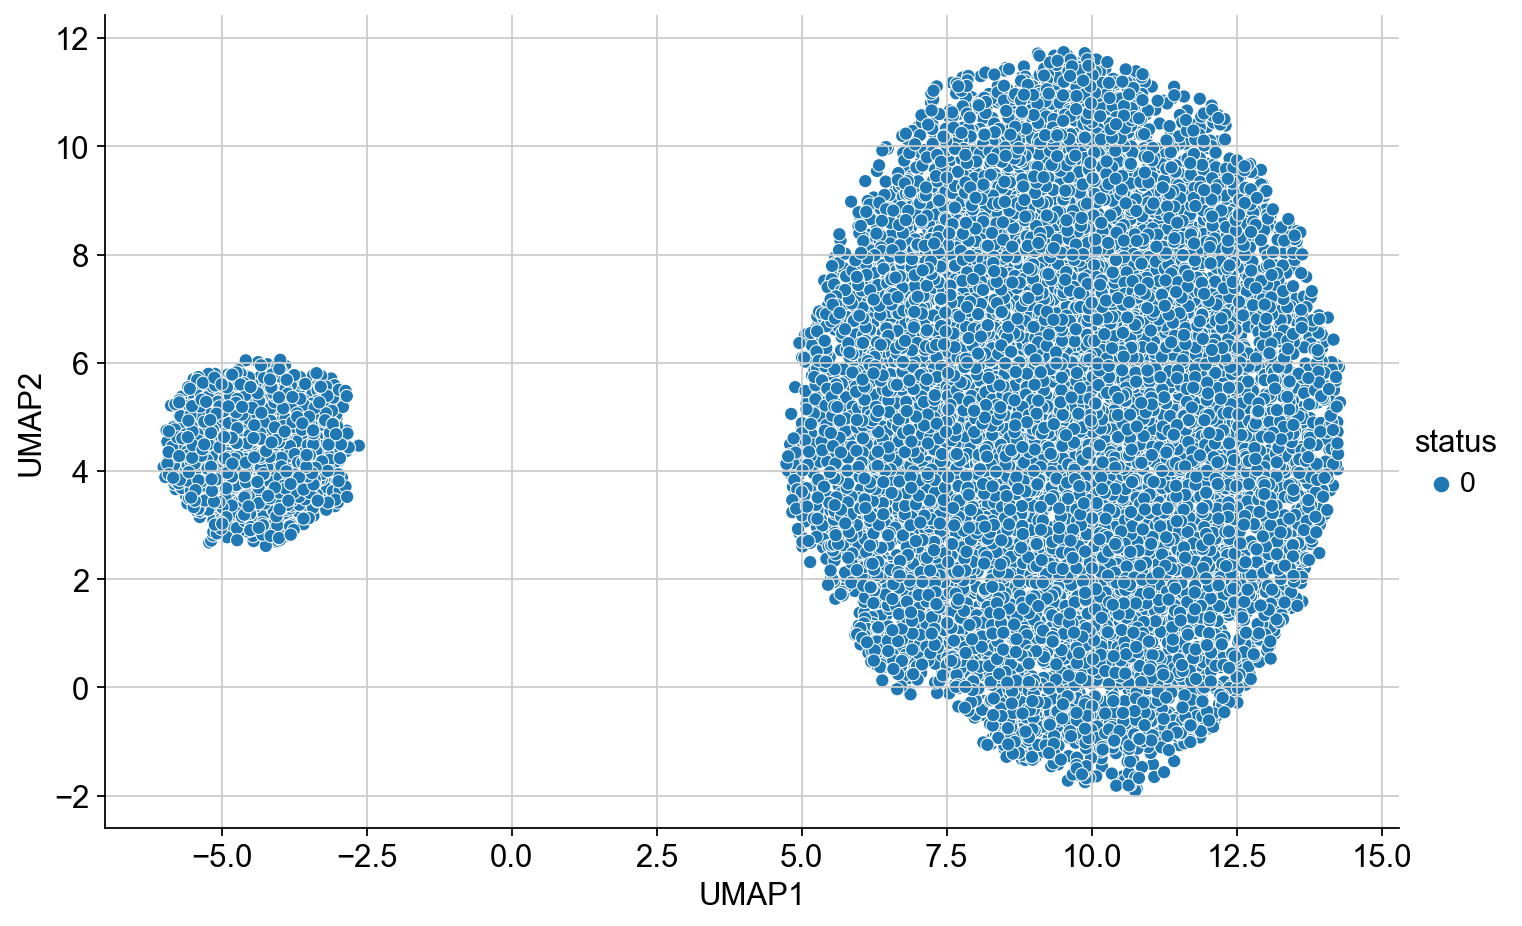

In [94]:
import seaborn as sns
umap_output['status'] = np.where(umap_output.guide=="hsa-miR-10527-5p", 1, 0)
sns_plot = sns.relplot(
    x="UMAP1", y="UMAP2", hue="status", data=umap_output,
    height=6, aspect=1.5)